# Visualization of basic data

We will retrive following data from various sources for the visualization:

1) Stock price and volume history

2) Stock sentiment from various sources - we might load some preprocesed sentiment


In [3]:
import yahooquery
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.units as munits
import datetime
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

In [4]:
# These should be commonly available in github and we import that module here

def get_yahoo_news(symbol,date):
    '''
    :symbol: Stock symbol. String
    :date: date from which news history must be obtained. String
    get all the available news until the specified date. For example if date is 2021-01-29, this returns 
    summary of all news up to 2021-01-29. In general, Yahoo keeps history of only 12 months hence we can only 
    12 months of news
    '''
    #start_date = date(2020, 6, 1)
    #end_date = date(2021, 1, 29)
    data = []
    run_Dict = []
    ticker = yahooquery.Ticker(symbol)
      
    news = ticker.news(5000,start=date)
    news = pd.DataFrame(news)
    
    news=news[["provider_publish_time","title", "summary"]]
    #news['date'] = pd.fr(news['provider_publish_time']).dt.strftime('%m-%d-%Y')
    news = news.sort_values(by=['provider_publish_time'])
    news['date'] = pd.to_datetime(news['provider_publish_time'],unit='s').dt.strftime("%Y-%m-%d")
    news.set_index(pd.to_datetime(news['date']), inplace=True)
    news.drop('date', axis=1)
    nltk.download("vader_lexicon")
    sentimentAnalyser = SentimentIntensityAnalyzer()

    news["compound"] = [sentimentAnalyser.polarity_scores(v)['compound'] if isinstance(v,str) else v for v in news["summary"]]
    news["negative"] = [sentimentAnalyser.polarity_scores(v)['neg'] if isinstance(v,str) else v for v in news["summary"]]
    news["positive"] = [sentimentAnalyser.polarity_scores(v)['pos'] if isinstance(v,str) else v for v in news["summary"]]
    news["neutral"] = [sentimentAnalyser.polarity_scores(v)['neu'] if isinstance(v,str) else v for v in news["summary"]]


    #news['date'] = pd.to_datetime(news['date']).
    print(news.columns)
    return news

def get_sentiment_from_news(news):
    news_sentiment = news[['date', 'compound']]
    news_sentiment.set_index(pd.to_datetime(news_sentiment['date']), inplace=True)
    news_sentiment = news_sentiment['compound']
    total_sentiment = news_sentiment.groupby('date').agg(lambda x: sum(x))
    total_sentiment = total_sentiment.rename('Total Sentiment')
    nArticles = news_sentiment.groupby('date').count()
    avg_sentiment = total_sentiment/nArticles
    avg_sentiment = avg_sentiment.rename('Avg Sentiment')
    sentiment_data = pd.concat([total_sentiment, avg_sentiment], axis=1)
    sentiment_data = sentiment_data.reindex(news.index, method='ffill')
    return sentiment_data

In [5]:
def get_yahoo_dataframe(symbol,start_date,end_date):
  # Get historical data
  #symbol = 'AAPL'
    ticker = yahooquery.Ticker(symbol)
    df=data.DataReader(symbol, 'yahoo', start_date, end_date).reset_index()
    df.set_index(pd.to_datetime(df['Date']), inplace=True)
    df = df.drop(['Date'], axis=1)
    return df

def process_stock_data(filename, df):
    stock_file = pd.read_csv(filename)
    stock_file.set_index(pd.to_datetime(stock_file['Date']), inplace=True)
    stock_file.drop('Date', axis=1)
    stock_file = stock_file.reindex(df.index, method='bfill')
    stock_file = stock_file.drop('Date', axis=1)
    stock_file = stock_file.drop('Period Ending', axis=1)
    return stock_file

## Input parameters - change these for specific stocks of interest


In [22]:
symbol='GME'
start_date = '2021-01-01'
end_date = '2021-01-13'

## Basic stock data plots

In [23]:
#get stock history
df = get_yahoo_dataframe(symbol,start_date,end_date)

### Price over time

Text(0.5, 1.0, 'GME chart')

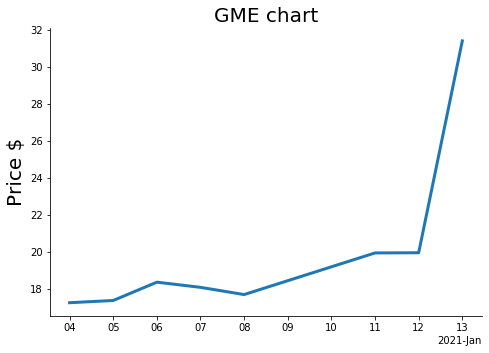

In [24]:
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(df[['Adj Close']],lw=3)
ax.set_ylabel('Price $',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
    
ax.set_title('{} chart'.format(symbol),fontsize=20)

### Price vs Volume with moving average
Plot also selects subset of data to focus as necessary

In [35]:
#get data for symbol
symbol = 'NVDA'
start_date = '2019-09-01'
end_date = '2020-09-01'
df = get_yahoo_dataframe(symbol,start_date,end_date)
# add a column for moving average
moving_avg_period = 20
df['20 day MA']=df['Adj Close'].rolling(moving_avg_period).mean()

new_df = df
#Limit data to second half of 2020 (optional)
#sub_start_date = '2021-01-01'
#sub_end_date = '2021-03-04'
#new_df = df.loc[sub_start_date:sub_end_date,:]

In [36]:
newdf

,High,Low,Open,Close,Volume,Adj Close,20 day MA
Date,,,,,,,
2019-09-03,165.910004,163.250000,164.580002,164.169998,7403500.0,163.778687,NaN
2019-09-04,169.059998,166.610001,166.610001,168.759995,5693200.0,168.357742,NaN
2019-09-05,179.990005,172.800003,172.869995,179.740005,17391900.0,179.311600,NaN
2019-09-06,181.089996,177.119995,178.800003,178.649994,9424400.0,178.224182,NaN
2019-09-09,183.979996,179.839996,179.899994,180.500000,10438100.0,180.069794,NaN
...,...,...,...,...,...,...,...
2020-08-26,514.739990,507.109985,511.970001,510.920013,8031100.0,510.616364,466.831876
2020-08-27,514.000000,502.660004,511.260010,505.130005,7940100.0,504.829773,470.857982
2020-08-28,525.919983,505.700012,507.000000,525.909973,13429000.0,525.597412,475.920970


Text(0.5, 1.0, 'NVDA chart')

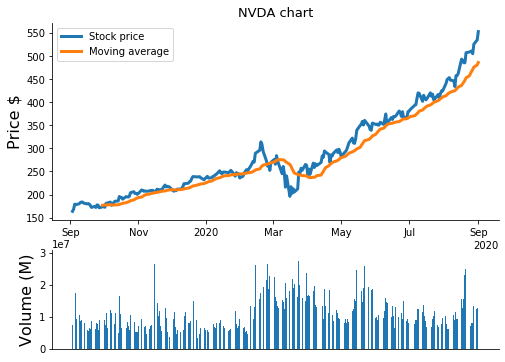

In [37]:
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

spec = gridspec.GridSpec(2,1, height_ratios=[4,2])
#fig, axs = plt.subplots(2, 1,  constrained_layout=True, figsize=(6, 6))
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[1,0])

ax1.plot(new_df['Adj Close'], lw=3)
ax1.plot(new_df['20 day MA'], lw=3)
ax1.legend(('Stock price','Moving average'))
ax1.set_ylabel('Price $',fontsize=16)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.axes.get_xaxis().set_visible(False)
ax2.bar(new_df['Volume'].index,new_df['Volume'])
ax2.set_ylabel('Volume (M)',fontsize=16)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax1.set_title('{} chart'.format(symbol),fontsize=13)

### Price vs revenues

In [38]:
#get data for symbol
symbol='NVDA'
start_date = '2019-09-01'
end_date = '2020-09-01'
df = get_yahoo_dataframe(symbol,start_date,end_date)

#Get revenue data - previously downloaded and stored in CSV
stock_file=process_stock_data("./earnings_data/{}.csv".format(symbol), df)
df = df.join(stock_file)

Text(0.5, 1.0, 'NVDA chart')

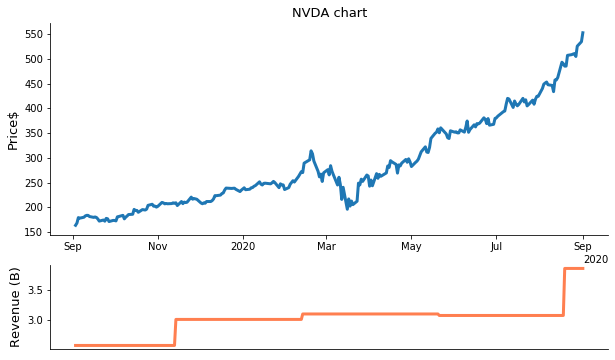

In [39]:
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

spec = gridspec.GridSpec(2,1, height_ratios=[5,2])

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(spec[1,0])
ax2 = fig.add_subplot(spec[0,0])

ax1.plot(df['Reported_Revenue']/1000, lw=3,color='coral')
ax1.set_ylabel('Revenue (B)',fontsize=13)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)

ax2.plot(df['Adj Close'],lw=3)
ax2.set_ylabel('Price$',fontsize=13)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.set_title('{} chart'.format(symbol),fontsize=13)

### Sentiment data for a stock

#### Sentiment from Yahoo news

In [14]:
end_date = '2021-03-04'
news = get_yahoo_news(symbol,end_date)
sentiment_data=get_sentiment_from_news(news)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sagarjogadhenu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Index(['provider_publish_time', 'title', 'summary', 'date', 'compound',
       'negative', 'positive', 'neutral'],
      dtype='object')


In [15]:
news = news.rename(columns={'date':'Date'})
article_count=news.groupby(['Date'])[['title']].count().sort_index()
article_count.index = article_count.index.astype('datetime64[ns]')

Text(0.5, 1.0, 'AMZN News')

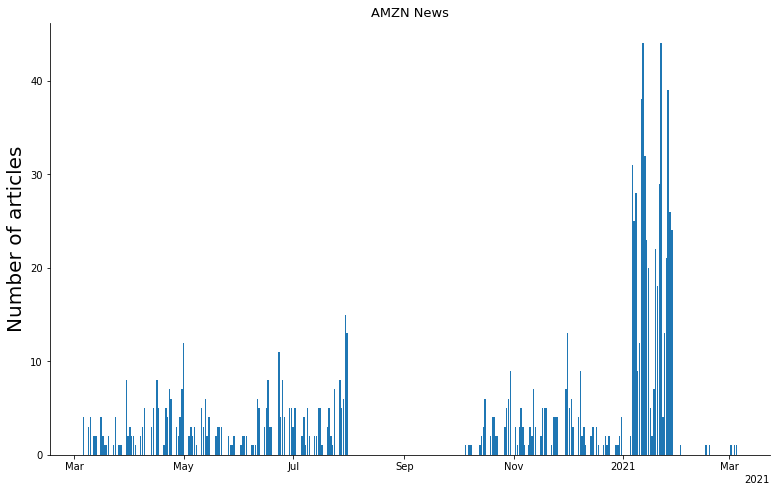

In [17]:
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(article_count.index,article_count['title'] )
ax.set_ylabel('Number of articles',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('{} News'.format(symbol),fontsize=13)

In [18]:
s= news.groupby('Date')[['negative', 'positive', 'neutral']].sum()

In [19]:
s.index = s.index.astype('datetime64[ns]')

Text(0.5, 1.0, 'AMZN News sentiment')

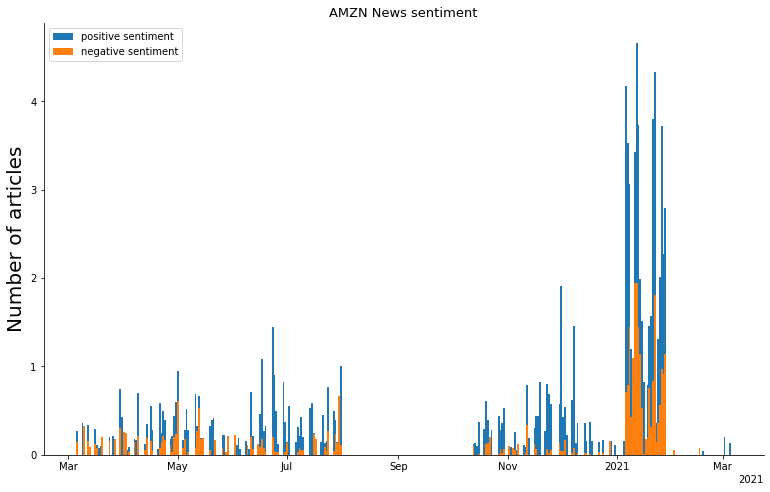

In [20]:
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(s.index,s['positive'],width=1,label='positive sentiment')
ax.bar(s.index,s['negative'],width=1,label='negative sentiment')
plt.legend(loc="upper left")
#ax.bar(s.index,s['neutral'])
ax.set_ylabel('Number of articles',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('{} News sentiment'.format(symbol),fontsize=13)

### Twitter sentiment data

In [21]:

symbol = 'PANW'
sentiment_data1=pd.read_csv('./twitter_scrapper/twitter_avgData/{}_Twitavg.csv'.format(symbol))
symbol = 'MELI'
sentiment_data=pd.read_csv('./twitter_scrapper/twitter_avgData/{}_Twitavg.csv'.format(symbol))


In [22]:
sentiment_data['Date'] = sentiment_data['Unnamed: 0']
sentiment_data = sentiment_data.set_index('Date')
sentiment_data1['Date'] = sentiment_data1['Unnamed: 0']
sentiment_data1 = sentiment_data1.set_index('Date')

In [23]:
sentiment_data.index = sentiment_data.index.astype('datetime64[ns]')
sentiment_data1.index = sentiment_data1.index.astype('datetime64[ns]')

In [24]:
sentiment_data.columns

Index(['Unnamed: 0', 'Daily average', 'weekly average', 'monthly average',
       'long term average', 'short term average'],
      dtype='object')

Text(0.5, 1.0, 'MELI and PANW News sentiment overlay')

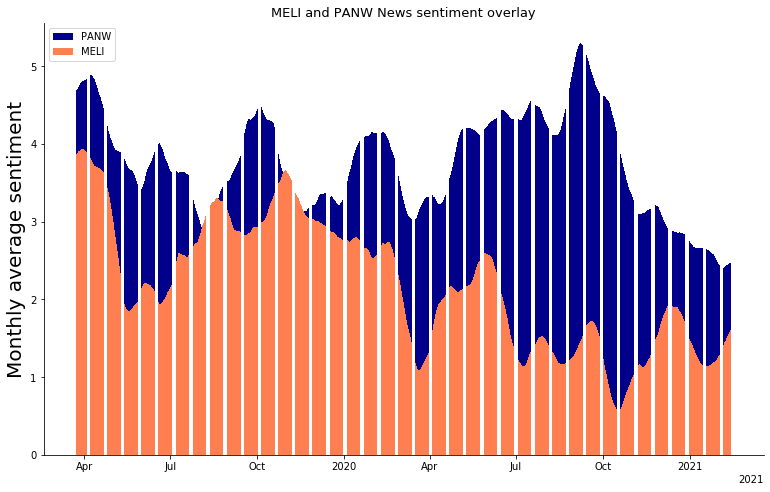

In [25]:
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(sentiment_data.index, sentiment_data['monthly average'],color='darkblue',label='PANW')
ax.bar(sentiment_data1.index, sentiment_data1['monthly average'],color='coral',label='MELI')
#ax.bar(s.index,s['neutral'])
plt.legend(loc="upper left")
ax.set_ylabel('Monthly average sentiment',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('MELI and PANW News sentiment overlay'.format(symbol),fontsize=13)

### Comparision between Reddit, Twitter and News sentiment

In [26]:
symbol = 'BABA'
t_sentiment=pd.read_csv('./twitter_scrapper/twitter_avgData/{}_Twitavg.csv'.format(symbol))
r_sentiment = pd.read_csv('./reddit_data/sentiment_avg/{}_avg.csv'.format(symbol))
end_date = '2021-03-03'
news = get_yahoo_news(symbol,end_date)
n_sentiment=get_sentiment_from_news(news)
n_sentiment['Monthly Sentiment'] = n_sentiment['Avg Sentiment'].rolling(20, win_type='triang').mean()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sagarjogadhenu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Index(['provider_publish_time', 'title', 'summary', 'date', 'compound',
       'negative', 'positive', 'neutral'],
      dtype='object')


In [27]:
t_sentiment.rename({'Unnamed: 0': 'Date', 'monthly average':'t_m average'}, axis=1,inplace=True)
t_sentiment = t_sentiment.set_index('Date')
t_sentiment.index = t_sentiment.index.astype('datetime64[ns]')
r_sentiment.rename({'Unnamed: 0': 'Date', 'monthly average':'r_m average'}, axis=1,inplace=True)
r_sentiment = r_sentiment.set_index('Date')
r_sentiment.index = r_sentiment.index.astype('datetime64[ns]')

In [28]:
sentiment_data = pd.concat([t_sentiment, r_sentiment],axis=1)

In [29]:
sentiment_data = sentiment_data.join(n_sentiment)

In [30]:
sentiment_data = sentiment_data.fillna(0)

Text(0.5, 1.0, 'Comparision of different sentiment sources')

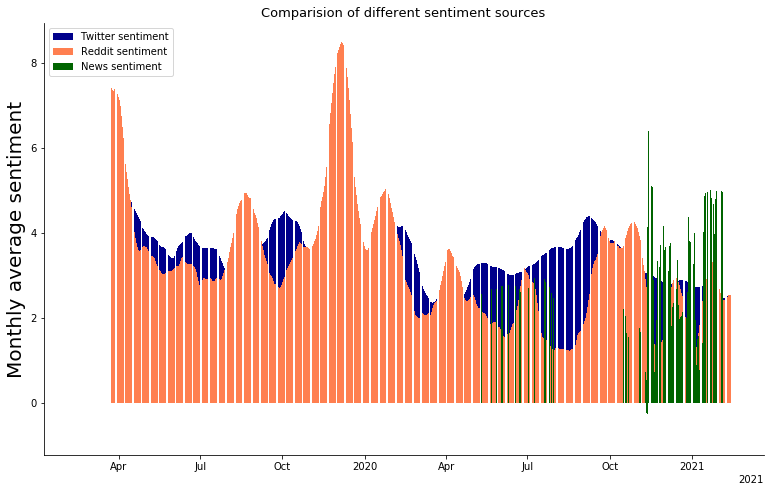

In [31]:
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

fig = plt.figure(figsize=(10,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(sentiment_data.index, sentiment_data['t_m average'],color='darkblue', label='Twitter sentiment')
ax.bar(sentiment_data.index, sentiment_data['r_m average']*2,color='coral',label='Reddit sentiment')
ax.bar(sentiment_data.index, sentiment_data['Monthly Sentiment']*10,color='darkgreen',label='News sentiment')
plt.legend(loc="upper left")
ax.set_ylabel('Monthly average sentiment',fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Comparision of different sentiment sources'.format(symbol),fontsize=13)

### Sentiment vs Price

In [44]:
#get data for symbol
start_date = '2020-03-15'
end_date = '2021-01-29'
symbol = 'BABA'
df = get_yahoo_dataframe(symbol,start_date,end_date)

#Get revenue data - previously downloaded and stored in CSV
stock_file=process_stock_data('./earnings_data/{}.csv'.format(symbol), df)
df = df.join(stock_file)
news = get_yahoo_news(symbol,end_date)
n_sentiment=get_sentiment_from_news(news)
n_sentiment['Monthly Sentiment'] = n_sentiment['Avg Sentiment'].rolling(20, win_type='triang').mean()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sagarjogadhenu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Index(['provider_publish_time', 'title', 'summary', 'date', 'compound',
       'negative', 'positive', 'neutral'],
      dtype='object')


In [45]:
df = df.join(n_sentiment)

Text(0.5, 1.0, 'BABA chart')

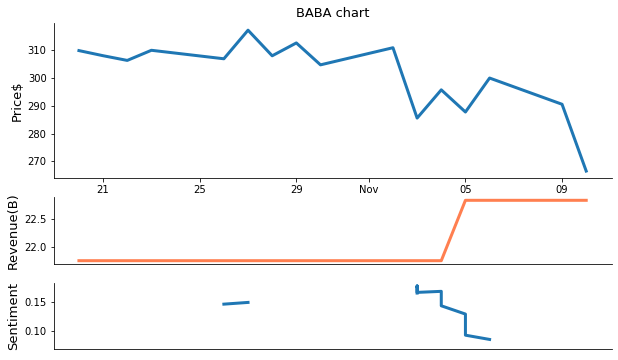

In [56]:
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

spec = gridspec.GridSpec(3,1, height_ratios=[7,3,3])

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[1,0])
ax3 = fig.add_subplot(spec[2,0])

ax1.plot(df.loc['2020-10-20':'2020-11-10','Adj Close'],lw=3)
ax1.set_ylabel('Price$',fontsize=13)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.plot(df.loc['2020-10-20':'2020-11-10','Reported_Revenue']/1000, lw=3,color='coral')
ax2.set_ylabel('Revenue(B)',fontsize=13)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

ax3.plot(df.loc['2020-10-20':'2020-11-10','Monthly Sentiment'], lw=3)
ax3.set_ylabel('Sentiment',fontsize=13)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.axes.get_xaxis().set_visible(False)

ax1.set_title('{} chart'.format(symbol),fontsize=13)